### Imports

In [49]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

### Dummy Submission (All-Positive)

This is our dummy submission where all values are assumed to be true. Score: 0.50689

In [2]:
def dummy_submit():
    submission_df = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')
    submission_df['Transported'] = True
    submission_df.to_csv('submission.csv', index=False)
    
# This is dummy, not real submit, comment out when you don't want dummy
# dummy_submit()

## Dataset Overview

In [2]:
train_df = pd.read_csv('../input/spaceship-titanic/train.csv')
test_df = pd.read_csv('../input/spaceship-titanic/test.csv') # Does NOT contain y -> 'Transported'

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Looking at the features of train_df, we can see that there are missing values in nearly all columns except for PassengerId and Transported.

Let's look at the data to see if there's anything that stands out.

HomePlanet
Earth     0.541922
Europa    0.250942
Mars      0.207136
Name: proportion, dtype: float64


<Axes: ylabel='HomePlanet'>

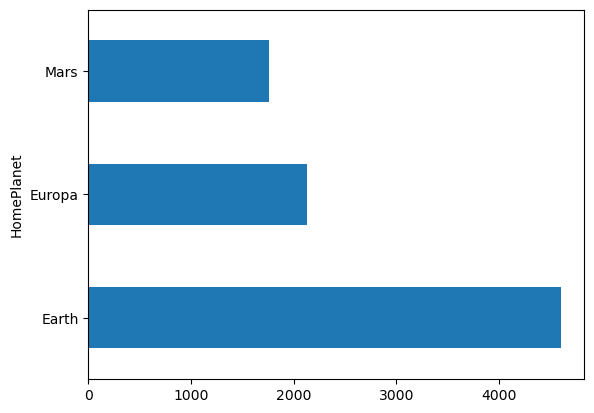

In [27]:
print(train_df.HomePlanet.value_counts(normalize=True))
train_df.HomePlanet.value_counts().plot.barh()

HomePlanet  Transported
Earth       False          0.576054
            True           0.423946
Europa      True           0.658846
            False          0.341154
Mars        True           0.523024
            False          0.476976
Name: proportion, dtype: float64


<Axes: xlabel='HomePlanet', ylabel='Transported'>

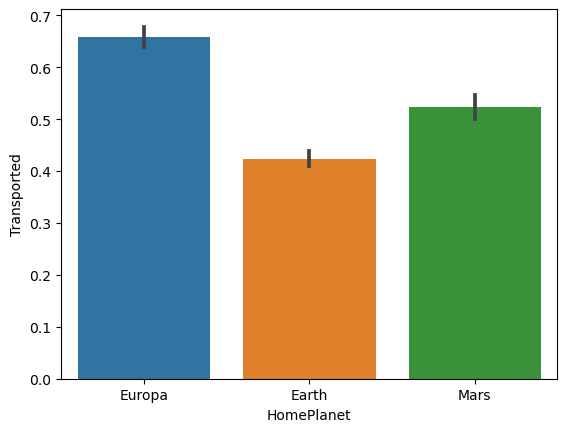

In [51]:
print(train_df.groupby("HomePlanet")["Transported"].value_counts(normalize=True))
sns.barplot(x="HomePlanet", y="Transported", data=train_df)

* It seems that Passengers from Europa are more likely to be transported. (65% chance)
* It seems that Passengers from Earth are less likely to be transported. (42% chance)

Destination
TRAPPIST-1e      0.694983
55 Cancri e      0.211491
PSO J318.5-22    0.093526
Name: proportion, dtype: float64


<Axes: ylabel='Destination'>

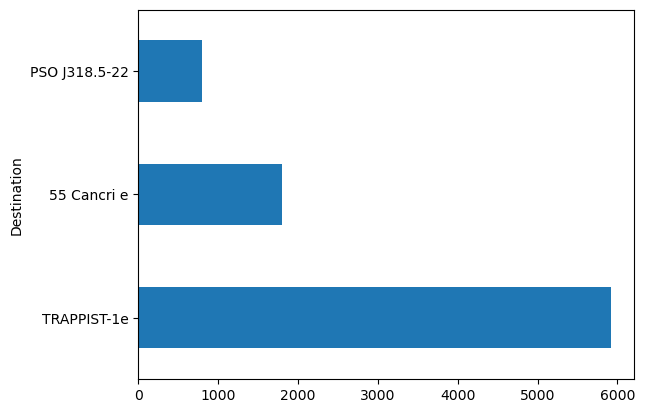

In [54]:
print(train_df.Destination.value_counts(normalize=True))
train_df.Destination.value_counts().plot.barh()

Destination    Transported
55 Cancri e    True           0.610000
               False          0.390000
PSO J318.5-22  True           0.503769
               False          0.496231
TRAPPIST-1e    False          0.528825
               True           0.471175
Name: proportion, dtype: float64


<Axes: xlabel='Destination', ylabel='Transported'>

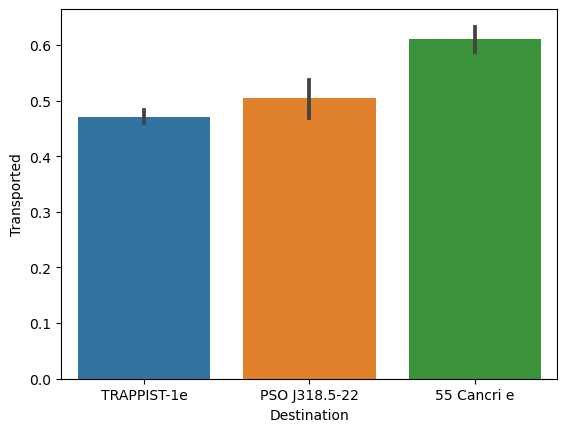

In [52]:
print(train_df.groupby("Destination")["Transported"].value_counts(normalize=True))
sns.barplot(x="Destination", y="Transported", data=train_df)

* It seems that Passengers going to "55 Cancri e" are more likely to be transported. (61% chance)

HomePlanet  Destination    Transported
Earth       55 Cancri e    True           0.504348
                           False          0.495652
            PSO J318.5-22  False          0.501404
                           True           0.498596
            TRAPPIST-1e    False          0.610771
                           True           0.389229
Europa      55 Cancri e    True           0.689616
                           False          0.310384
            PSO J318.5-22  True           0.736842
                           False          0.263158
            TRAPPIST-1e    True           0.634987
                           False          0.365013
Mars        55 Cancri e    True           0.611399
                           False          0.388601
            PSO J318.5-22  False          0.551020
                           True           0.448980
            TRAPPIST-1e    True           0.511864
                           False          0.488136
Name: proportion, dtype: float64


<Axes: xlabel='HomePlanet', ylabel='Transported'>

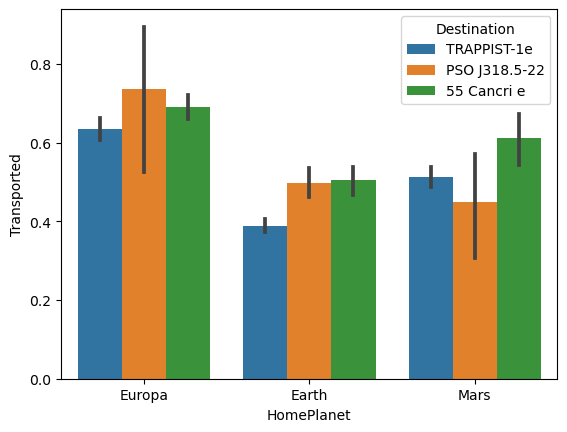

In [128]:
print(train_df.groupby(["HomePlanet", "Destination"])["Transported"].value_counts(normalize=True))
sns.barplot(x="HomePlanet", y="Transported", hue="Destination", data=train_df)

* It seems that Passengers from Earth and are going to TRAPPIST-1e are less likely to be transported. (38% chance)
* It seems that Passengers from Mars and are going to 55 Cancri e are more likely to be transported. (61% chance)


CryoSleep
False    0.641694
True     0.358306
Name: proportion, dtype: float64


<Axes: ylabel='CryoSleep'>

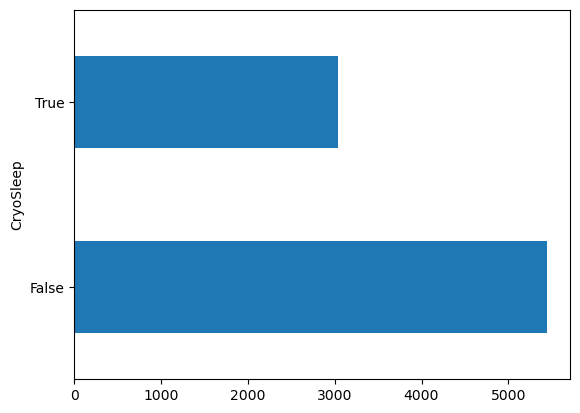

In [125]:
print(train_df.CryoSleep.value_counts(normalize=True))
train_df.CryoSleep.value_counts().plot.barh()

In [126]:
train_df.groupby("CryoSleep")[["Spa", "VRDeck", "ShoppingMall", "RoomService", "FoodCourt"]].aggregate(["min", "max"])

Spa          VRDeck          ShoppingMall          RoomService  \
           min      max    min      max          min      max         min   
CryoSleep                                                                   
False      0.0  22408.0    0.0  24133.0          0.0  23492.0         0.0   
True       0.0      0.0    0.0      0.0          0.0      0.0         0.0   

                   FoodCourt           
               max       min      max  
CryoSleep                              
False      14327.0       0.0  29813.0  
True           0.0       0.0      0.0

CryoSleep  Transported
False      False          0.671079
           True           0.328921
True       True           0.817583
           False          0.182417
Name: proportion, dtype: float64


<Axes: xlabel='CryoSleep', ylabel='Transported'>

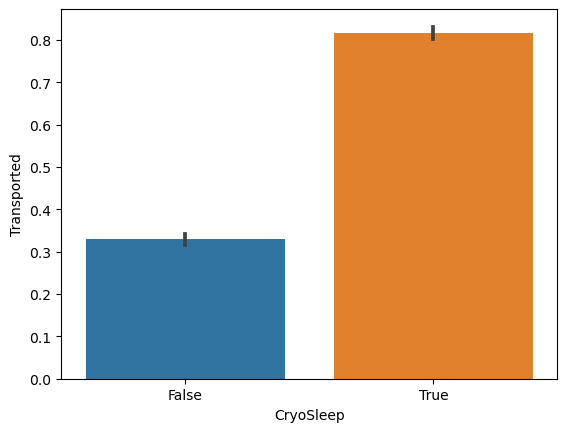

In [56]:
print(train_df.groupby("CryoSleep")["Transported"].value_counts(normalize=True))
sns.barplot(x="CryoSleep", y="Transported", data=train_df)

* It seems that Passengers in CryoSleep are HIGHLY likely to be transported! (81% chance)
* If a Passenger is in CryoSleep, THEY WILL NOT spend any money. We can fill all money values with 0, if a Passenger is sleeping.

VIP
False    0.976561
True     0.023439
Name: proportion, dtype: float64


<Axes: ylabel='VIP'>

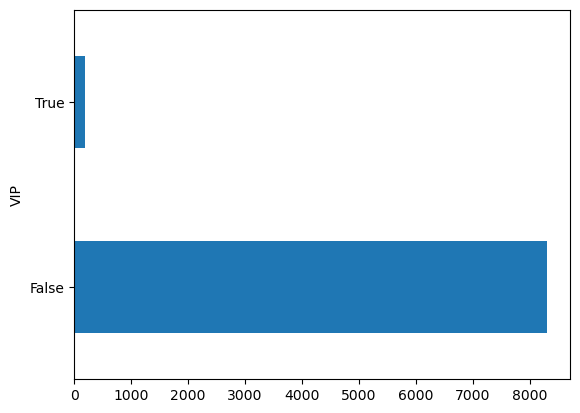

In [59]:
print(train_df.VIP.value_counts(normalize=True))
train_df.VIP.value_counts().plot.barh()

VIP    Transported
False  True           0.506332
       False          0.493668
True   False          0.618090
       True           0.381910
Name: proportion, dtype: float64


<Axes: xlabel='VIP', ylabel='Transported'>

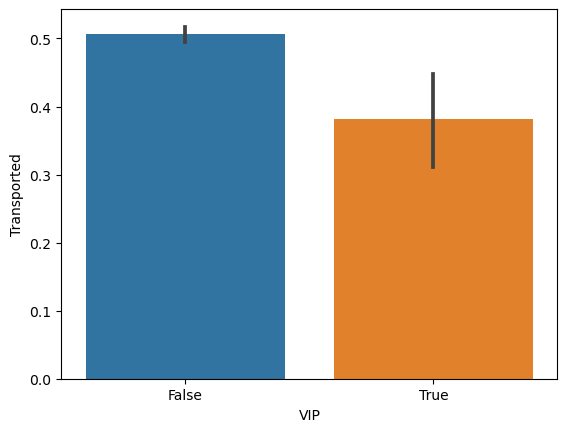

In [60]:
print(train_df.groupby("VIP")["Transported"].value_counts(normalize=True))
sns.barplot(x="VIP", y="Transported", data=train_df)

* It seems that Passengers that are VIPs are less likely to be Transported. (38% chance)

HomePlanet  VIP  
Earth       False    1.000000
Europa      False    0.937291
            True     0.062709
Mars        False    0.963287
            True     0.036713
Name: proportion, dtype: float64


<Axes: xlabel='HomePlanet', ylabel='VIP'>

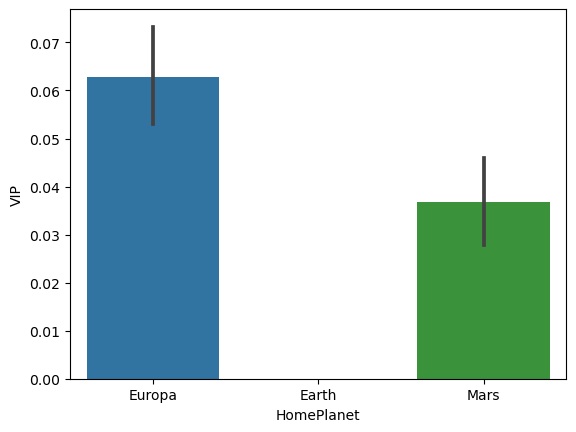

In [122]:
print(train_df.groupby("HomePlanet")["VIP"].value_counts(normalize=True))
sns.barplot(x="HomePlanet", y="VIP", data=train_df)

* It seems that Passengers from the HomePlanet Earth, WILL NOT be a VIP

Age
0.0     178
1.0      67
2.0      75
3.0      75
4.0      71
       ... 
75.0      4
76.0      2
77.0      2
78.0      3
79.0      3
Name: count, Length: 80, dtype: int64


<Axes: xlabel='Age'>

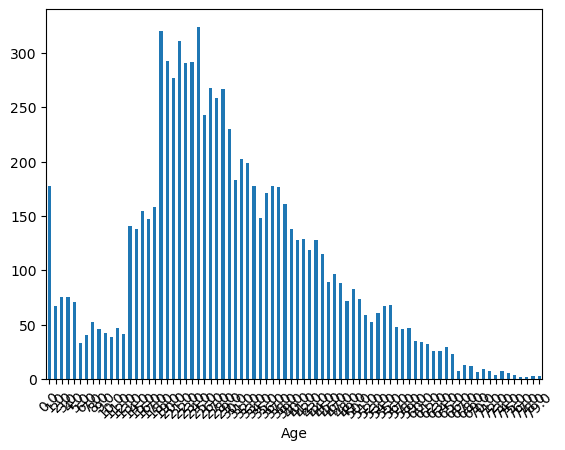

In [121]:
print(train_df.Age.value_counts().sort_index())
train_df.Age.value_counts().sort_values().sort_index().plot(kind='bar', rot=45)

In [ ]:
print(train_df.Age.value_counts().sort_index())
train_df.Age.value_counts().sort_values().sort_index().plot.bar()

Age  Transported
0.0  True           0.808989
     False          0.191011
Name: proportion, dtype: float64
Age  Transported
1.0  True           0.731343
     False          0.268657
Name: proportion, dtype: float64
Age  Transported
2.0  True           0.706667
     False          0.293333
Name: proportion, dtype: float64
Age  Transported
3.0  True           0.786667
     False          0.213333
Name: proportion, dtype: float64
Age  Transported
4.0  True           0.746479
     False          0.253521
Name: proportion, dtype: float64
Age  Transported
5.0  True           0.606061
     False          0.393939
Name: proportion, dtype: float64
Age  Transported
6.0  True           0.575
     False          0.425
Name: proportion, dtype: float64
Age  Transported
7.0  True           0.615385
     False          0.384615
Name: proportion, dtype: float64
Age  Transported
8.0  True           0.565217
     False          0.434783
Name: proportion, dtype: float64
Age  Transported
9.0  True        

<Axes: xlabel='Age', ylabel='Transported'>

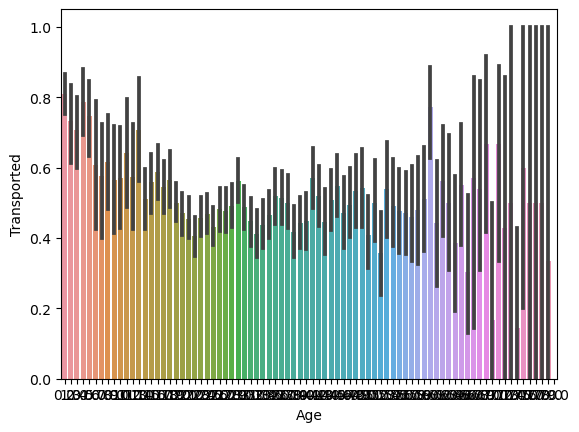

In [107]:
age_df = train_df.groupby("Age")["Transported"].value_counts(normalize=True)

print(age_df.iloc[0:2])
for i in range(2, age_df.size, 2):
    print(age_df.iloc[i:i+2])

sns.barplot(x="Age", y="Transported", data=train_df)

* It seems that Passengers that are between Ages 0-4 are HIGHLY Likely to be transported! (~70-80% chance)
* It seems that Passengers that are Ages, 21, 31, 37, 40, 49, 51,  are more likely to be transported. (~60% chance)
* There isn't enough data for Ages between 5-12, and >55 to trust the likelyhoods.


# Pre-processing

In [3]:
# Replaces whitespace with NaN
train_df.replace(r'^\s+$', np.nan, regex=True) 
test_df.replace(r'^\s+$', np.nan, regex=True)

def splitData(dataframe):
    # Split "PassengerId" into "GroupId" & "IndividualId"
    dataframe["GroupId"] = dataframe["PassengerId"].str.split("_").str[0]
    dataframe["IndividualId"] = dataframe["PassengerId"].str.split("_").str[1]

    # Split "Cabin" into "Deck", "Number", & "Side"
    dataframe["Deck"] = dataframe["Cabin"].str.split("/").str[0]
    dataframe["Number"] = dataframe["Cabin"].str.split("/").str[1]
    dataframe["Side"] = dataframe["Cabin"].str.split("/").str[2]

    dataframe.shape
    dataframe.sort_index()

    return dataframe

train_df = splitData(train_df)
test_df = splitData(test_df)

In [4]:
numeric_features = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "GroupId", "Number"] 
categorical_features = ["HomePlanet", "Destination", "Deck"] 
ordinal_features = [] 
binary_features = ["CryoSleep", "VIP", "Side"] 
drop_features = ["Name", "PassengerId", "IndividualId", "Cabin"]  # do not include these features in modeling
passthrough_features = [] # do not apply any transformation

target = "Transported"

X_train = train_df.drop(columns=[target, *drop_features])
y_train = train_df[target]

X_test = test_df.drop(columns=[*drop_features]) # test_df does NOT contain target